# Gaussian process regression

How do they work and how are they implemented in pymc?

This has partial pooling benefits.

Resources:
- [Chris Fonnesbeck GPR primer video](https://www.youtube.com/watch?v=j7Ruu3Yu-70)
- [Distill pub](https://distill.pub/2019/visual-exploration-gaussian-processes/)
- First half hour of [Richard Turner video](https://www.youtube.com/watch?v=92-98SYOdlY)
- [Kat Bailey post](https://katbailey.github.io/post/gaussian-processes-for-dummies/)
- [Statistical Rethinking 2022 lecture 16](https://www.youtube.com/watch?v=PIuqxOBJqLU&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=16)
- Statistical Rethinking 2019 lecture, election example
- [Pymc tutorial](https://docs.pymc.io/en/v3/Gaussian_Processes.html)

PyMC3 implementation is high-level while PyStan is low level.

In [1]:
import arviz as az
from matplotlib.patches import Ellipse, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
import scipy.linalg as linalg
import seaborn as sns
from theano import tensor as tt

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

[Chris Fonnesbeck GPR primer video](https://www.youtube.com/watch?v=j7Ruu3Yu-70) was helpful for this section.

We'll use the flexibility and non-linearity that Gaussian processes provides. The idea is that when you start with a big multivariate normal, there are two nice properties that we can take advantage of in GPR:
- any kind of slicing (marginilization) will give a multivariate Gaussian
- conditioning on some elements will also give a multivariate Gaussian

Gaussian distribution:

$$ y \sim N(\mu, \Sigma) $$

Gaussian process, generalize the multi-variate normal to contain not just many elements, but infinite elements.

$$ f \sim GP(m(x), k(x, x') )$$

Instead of a mean and covariance (as in Gaussian distribution), there's a mean *function* and covariance *function*. The idea is to just call the function you need at the time.

<p><span style="color:red">
What do the x, x' parameters represent?
</span></p>

> "an infinite collection of random variables, any finite subset of which have a Gaussian distribution"

It's not really non-parametric, it's an infinite number of parameters. Better way of thinking about it: the effective number of parameters scales with data.

For a realization of a Gaussian process it's not a number, but a function.

Functions that generate **covariance matrices**:

$$ \Sigma \sim k(x, x' | \phi) $$

Note that the function is parameterized by $\phi$ now. A common covariance function is the quadratic (AKA exponential quadratic AKA L2 norm):

$$ k(x, x') = \exp \left[- \frac {(x - x')^2}{2l^2} \right] $$

We can also call $x - x'$ as $d$ or distance.

$$ k(x, x') = \exp \left[-\frac {d^2}{2l^2}\right] $$

Confusingly, $\rho$ is used for the length scale sometimes, ergo:

$$ k(x, x') = \eta \exp \left[-\frac {(x - x')^2}{2\rho^2}\right] $$
$\eta$ and the 2 in the denominator is also optional and that can be left off.

$\sigma$ (McElreath) can also be used for the length scale term. The multiplier can also be $\alpha^2$

$$ k(x, x') = \alpha^2 \exp \left[-\frac {(x - x')^2}{\sigma^2} \right]$$

$\alpha^2$ -> maximum covariance
$\sigma^2$ -> scaling or length parameter

Instead of $\sigma^2$ being in the denominator, it can also be shown as a factor and implicitly known as 1/$\sigma^2$. In `pymc`, the former is parameterized with `ls` while the latter is `ls_inv`.

# RBF Kernel vs. McElreath's `cov_GPL2`


[Distll pub](https://distill.pub/2019/visual-exploration-gaussian-processes/)
$\sigma^2 \exp( -\frac{||t - t'||^2}{2l^2}  )$

where $\sigma$ is the variance (average distance away from the function's mean), $D$ is distance, $l$ is length (determines the reach of influence on neighbors; similar to $\rho$).

[Pymc repo](https://docs.pymc.io/en/stable/api/gp/cov.html) uses: `gp.cov.ExpQuad`
also known as Exponentiated Quadratic kernel, Squared Expontential, Radial Basis Function
same equation as above

McElreath's

$\eta^2\exp( -\rho^2D^2) + \delta\sigma^2$

where $\eta$ is the max covariance (we'll get from fitting to the data), $\rho$ is the rate of decline with distance (also fit from the data), $D$ is the squared distance, $\delta$ is the jigger term, $\sigma$ is the variance with itself.

$\eta^2$ was given an Exp(2) prior, so values would be all positive
$\rho^2$ was given an Exp(0.5) prior, so values would be all positive


Richard Turner [video](https://www.youtube.com/watch?v=92-98SYOdlY)
![7a37fcd06f8f19496f4f33ab546271ed.png](:/f46953717a3e4a78ad1e41fc05e11a3c)


Thanks @Marco. ... I think in the end, the RBF is functionally similar to McElreath's example. I probably spent too much time on this, but if it helps someone, here is what I've learned while navigating the confusion:
- Radial basis function (RBF) is also known as Exponentiated Quadratic kernel (pymc's reference) and Squared Expontential kernel.
- It doesn't help that Greek letters are being assigned differently across sources. A common depiction for RBF seems to be something like $\sigma^2 \exp( -\frac{||t - t'||^2}{2l^2}  )$ (shown in the Distill pub) while McElreath's was  $\eta^2\exp( -\rho^2D^2)$ (I'm leaving off the last term). 
- $||t - t'||^2$ is the same as $D^2$.
- Functionally $\sigma^2$ is serving the same purpose as $\eta^2$ (maximum covariance), but some don't even bother including this term.
- The hardest thing to see was how $2l^2$ could related to McElreath's $\rho^2$. They both control how neighboring points may influence each other. McElreath put an Exponential prior for $\rho^2$ so they're all positive. I saw one of the sources give $l$ a fractional value which is how it can be greater than 1.
- I can't find the code for `cov_GPL2` which would help see what's going on with the parameters we pass through it


In [9]:
d = np.linspace(0, 1, 100)
d

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'distance'),
 Text(0, 0.5, 'covariance'),
 Text(0.5, 1.0, 'check axes')]

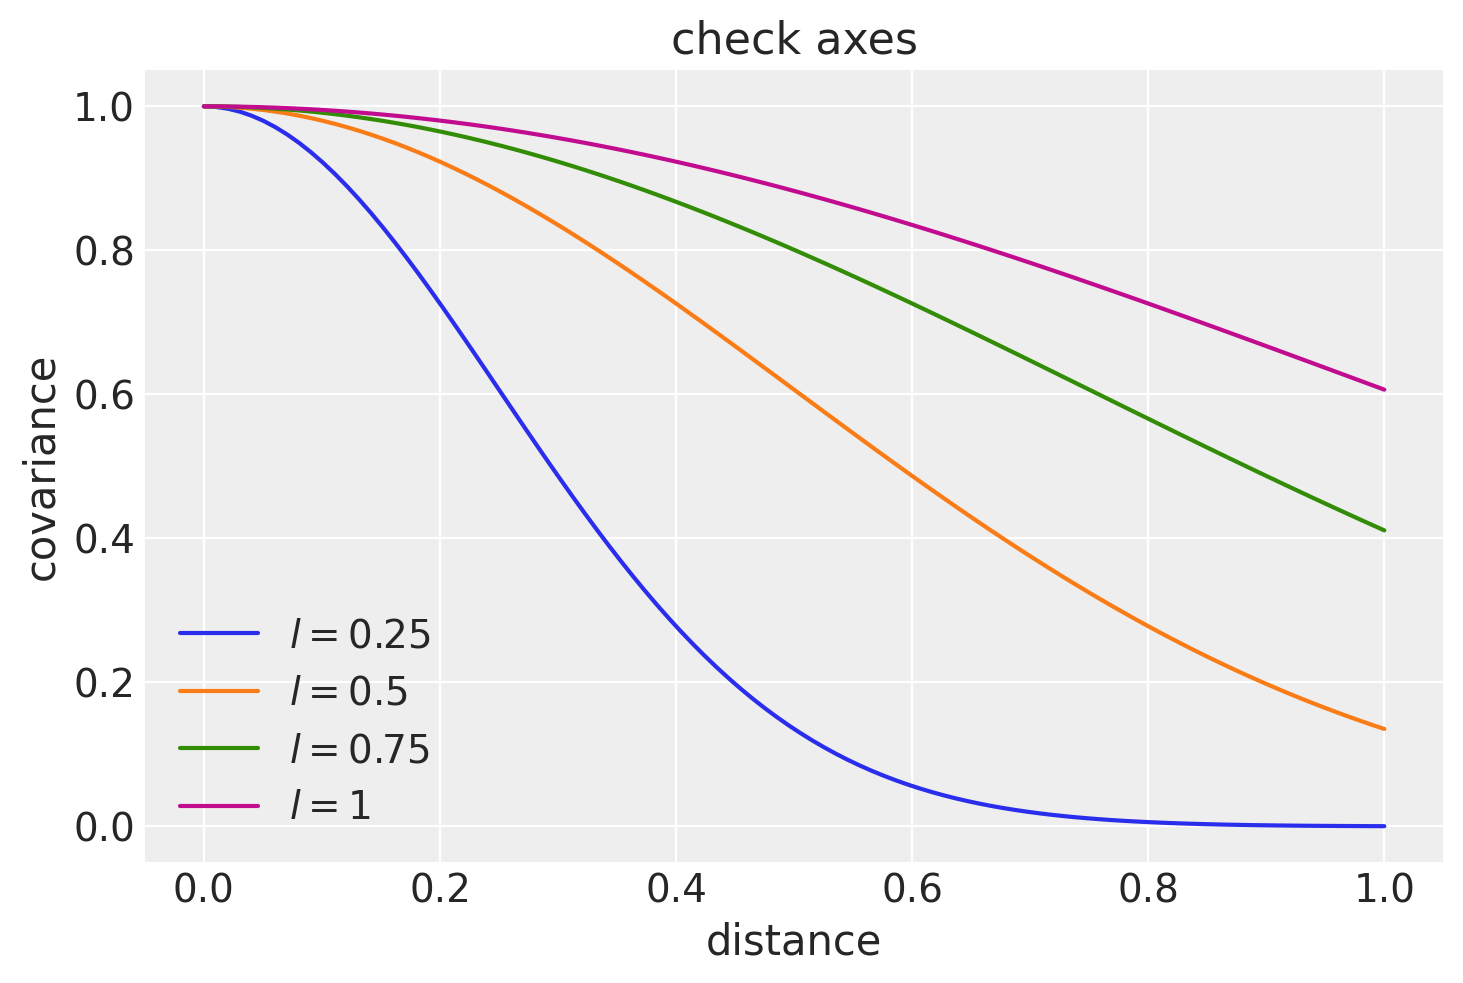

<IPython.core.display.Javascript object>

In [24]:
l = 1

f, ax0 = plt.subplots()
for l in [0.25, 0.5, 0.75, 1]:
    ax0.plot(d, np.exp(-(d**2 / (2 * l**2))), label=f"$l={l}$")
    # ax0.plot(d, np.exp(-(d**2 / (l**2))), label=f"$l={l}$")
ax0.legend()
ax0.set(xlabel='distance', ylabel='covariance', title='check axes')

The length scale determines how correlated things can be as they get further apart.

Now draw from the Gaussian process prior. Again, it's a distribution over functions, not a distribution over values. (AKA a kernel function.)

$$ y \sim GP(m=0, k=\text{Quad}(1)) $$

<p><span style="color:red">
The parameter for Quad(1) represents the lengthscale. Anything wrong with above graph?
</p></span>

Generate functions from this prior by taking draws from this distribution of functions.

When we add a point, it constrains the space where functions can possibly go.

In reality, the kernel is also being learned when data is added.

# Islands problem

Re-do islands problem from [lecture 16](https://speakerdeck.com/rmcelreath/statistical-rethinking-2022-lecture-16).

Except simplify ... do a 45 dimensional Gaussian matrix.

In [29]:
os.listdir(DATA_DIR)

['Hoogland.csv',
 'homeworkch3.R',
 'tulips.csv',
 'PrussianHorses.csv',
 'Fish.csv',
 'reedfrogs.csv',
 'week08_Monks.csv',
 'Dinosaurs.csv',
 'rugged.csv',
 'Hurricanes.csv',
 'Kline2.csv',
 'islands.csv',
 'salamanders.csv',
 'galapagos.csv',
 'bangladesh.csv',
 'Primates301_nex.rda',
 'elephants.csv',
 'eagles.csv',
 'islandsDistMatrix.rda',
 'Achehunting.csv',
 'Panda_nuts.csv',
 'WaffleDivorce.csv',
 'Boxes_model.rda',
 'foxes.csv',
 'Moralizing_gods.csv',
 'nettle.csv',
 'AMTL.csv',
 'AMTL_short.csv',
 'Laffer.csv',
 'Primates301.csv',
 'Trolley.csv',
 'UFClefties.csv',
 'Oxboys.csv',
 'Lynx_Hare_model.rda',
 'wikipedia_lds.csv',
 'Kline.csv',
 'Wolfdice.csv',
 'Lynx_Hare.csv',
 'Mites.csv',
 'Primates301_distance_matrix.rda',
 'Dissertations.csv',
 'nst-est2019-alldata.csv',
 'Boxes.csv',
 'Fieldgoals.csv',
 'UCBadmit.csv',
 'milk.csv',
 'Crofoot.csv',
 'AustinCats.csv',
 'cherry_blossoms.csv',
 'NWOGrants.csv',
 'KosterLeckie.rda',
 'Primates301_vcov_matrix.rda',
 'willowtitn.

<IPython.core.display.Javascript object>

In [30]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_islands = pd.read_csv(DATA_DIR + "islands.csv", sep=";", header=0)
df_islands.head()



,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0


<IPython.core.display.Javascript object>

In [123]:
Dmat = pd.read_csv(DATA_DIR + "islandsDistMatrix.csv", sep=",", header=0, index_col=0)
Dmat.head()

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884


<IPython.core.display.Javascript object>

Let's start with a simplified model that uses a regular linear model with log link function.

## MVN with conventional covariance matrix

$$ S_i \sim \text{Poisson}(\lambda_i) $$
$$ \log\lambda_i = \bar{\alpha} + \alpha_{S[i]} $$
$$ \begin{bmatrix}\alpha_1 \\ \alpha_2 \\ ... \\ \alpha_{10} \end{bmatrix} \sim \text {MVNormal } \left( \begin{bmatrix} 0 \\ 0 \\ ... \\ 0 \end{bmatrix} , K \right)  \tag{MVNormal with covariance matrix kernel} $$

We still want to do varying effects and one way to construct it is with this multi-variate normal prior to show the relationships between islands. The co-variance matrix can be constructed using a huge 10x10 covariance matrix but there's a clever way to construct it using a Gaussian process prior. Let's do it the hard way first so it's clear what we're doing. We can use the Cholesky factors.

In [37]:
n_islands = len(df_islands['culture'].unique())
id_isle = df_islands.index
a_bar = np.log(df_islands['total_tools'].mean())

<IPython.core.display.Javascript object>

In [89]:
with pm.Model() as mMVNc:
    """
    Centered model
    """

    # vector of means for MVNormal
    mus = pm.Normal("mus", mu=0, sd=1, shape=n_islands)

    # variances for covariance matrix
    sd_dist = pm.Exponential.dist(1.0)
    chol, corr, sigmas = pm.LKJCholeskyCov("chol", n=n_islands, eta=4, sd_dist=sd_dist, compute_corr=True)
    # n=2 for each pair of islands

    a = pm.MvNormal(
        "a", mu=mus, chol=chol, shape=n_islands
    )  # population of varying effects
    # shape needs to be ... 

    # linear models
    lam = pm.Deterministic("lam", pm.math.exp(a_bar + a[id_isle]))

    # likelihood
    t = pm.Poisson("t", lam, observed=df_islands['total_tools'])

    trace_mMVNc = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, chol, mus]
INFO:pymc3:NUTS: [a, chol, mus]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.
There were 342 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 342 divergences after tuning. Increase `target_accept` or reparameterize.
There were 442 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 442 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6145496237303041, but should be close to 0.8. Try to increase the number of tuning steps.
There were 387 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 387 divergences after tuning. Increase `target_accept` or reparameterize.
There were 566 divergences after tuning. Increase `target_accept` or reparameteri

<IPython.core.display.Javascript object>

In [90]:
az.summary(trace_mMVNc, var_names="a")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.976,0.290,-1.392,-0.546,0.031,0.022,85.0,85.0,102.0,295.0,1.03
a[1],-0.463,0.208,-0.774,-0.121,0.009,0.007,528.0,445.0,571.0,553.0,1.02
a[2],-0.381,0.211,-0.737,-0.101,0.012,0.014,318.0,119.0,442.0,277.0,1.03
a[3],0.200,0.148,-0.045,0.419,0.007,0.005,422.0,422.0,440.0,813.0,1.01
a[4],-0.051,0.162,-0.321,0.182,0.012,0.008,184.0,184.0,180.0,589.0,1.02
a[5],-0.617,0.219,-0.951,-0.272,0.008,0.006,728.0,728.0,687.0,1424.0,1.01
a[6],0.101,0.171,-0.203,0.334,0.030,0.022,32.0,32.0,39.0,9.0,1.07
a[7],-0.208,0.180,-0.504,0.061,0.008,0.005,558.0,558.0,540.0,1061.0,1.01
a[8],0.441,0.140,0.238,0.678,0.009,0.006,237.0,237.0,261.0,510.0,1.02
a[9],0.701,0.122,0.544,0.921,0.011,0.008,113.0,105.0,115.0,332.0,1.03


<IPython.core.display.Javascript object>

In [82]:
az.summary(trace_mMVNc, var_names="lam")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"lam[0,0]",12.922,1.628,10.164,15.079,0.096,0.068,285.0,285.0,246.0,192.0,1.02
"lam[0,1]",22.025,1.999,18.615,24.711,0.084,0.059,570.0,570.0,498.0,999.0,1.02
"lam[0,2]",23.865,2.159,20.771,27.178,0.179,0.127,145.0,145.0,143.0,430.0,1.02
"lam[0,3]",43.056,2.914,38.667,47.267,0.228,0.161,164.0,164.0,170.0,181.0,1.02
"lam[0,4]",32.977,2.644,28.943,36.768,0.298,0.211,79.0,79.0,75.0,684.0,1.04
...,...,...,...,...,...,...,...,...,...,...,...
"lam[9,5]",19.133,1.946,16.230,22.151,0.204,0.151,91.0,84.0,109.0,243.0,1.03
"lam[9,6]",39.814,2.730,35.592,44.080,0.342,0.243,64.0,64.0,66.0,192.0,1.05
"lam[9,7]",27.720,2.294,24.242,31.434,0.101,0.071,518.0,518.0,491.0,349.0,1.04
"lam[9,8]",55.035,3.377,49.211,59.864,0.173,0.122,383.0,383.0,371.0,490.0,1.02


<IPython.core.display.Javascript object>

In [115]:
az.summary(trace_mMVNc, var_names="chol")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
chol[0],0.826,0.765,0.033,1.692,0.029,0.021,680.0,680.0,306.0,233.0,1.01
chol[1],-0.016,0.258,-0.356,0.332,0.010,0.007,658.0,658.0,701.0,297.0,1.02
chol[2],0.716,0.688,0.027,1.561,0.034,0.024,400.0,400.0,201.0,81.0,1.02
chol[3],-0.027,0.262,-0.410,0.306,0.022,0.016,141.0,141.0,84.0,276.0,1.04
chol[4],-0.006,0.240,-0.335,0.271,0.011,0.008,444.0,444.0,295.0,702.0,1.01
chol[5],0.794,0.709,0.050,1.592,0.044,0.031,261.0,261.0,202.0,527.0,1.03
chol[6],0.010,0.235,-0.339,0.336,0.009,0.007,668.0,646.0,225.0,671.0,1.02
chol[7],-0.005,0.242,-0.311,0.328,0.031,0.022,62.0,62.0,45.0,451.0,1.06
chol[8],-0.002,0.245,-0.303,0.359,0.009,0.008,816.0,500.0,849.0,492.0,1.02
chol[9],0.668,0.601,0.037,1.391,0.037,0.026,263.0,263.0,212.0,423.0,1.02


<IPython.core.display.Javascript object>

There's 55 values, one for each island's variance for itself (10) and then one for each unique co-variance pair (45).

In [116]:
az.summary(trace_mMVNc, var_names="chol_corr")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_corr[0,1]",-0.015,0.241,-0.410,0.372,0.009,0.010,744.0,289.0,777.0,486.0,1.01
"chol_corr[0,2]",-0.019,0.248,-0.424,0.361,0.022,0.023,127.0,60.0,173.0,43.0,1.03
"chol_corr[0,3]",0.008,0.228,-0.357,0.370,0.008,0.006,828.0,828.0,855.0,1485.0,1.01
"chol_corr[0,4]",-0.001,0.235,-0.380,0.366,0.008,0.006,769.0,753.0,784.0,1223.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
"chol_corr[9,5]",-0.025,0.232,-0.353,0.371,0.015,0.010,249.0,249.0,286.0,1689.0,1.02
"chol_corr[9,6]",-0.008,0.237,-0.382,0.364,0.010,0.008,582.0,431.0,595.0,1401.0,1.06
"chol_corr[9,7]",-0.002,0.243,-0.363,0.421,0.012,0.009,444.0,334.0,454.0,234.0,1.02
"chol_corr[9,8]",-0.021,0.233,-0.333,0.396,0.023,0.016,105.0,105.0,115.0,1439.0,1.03


<IPython.core.display.Javascript object>

In [53]:
az.summary(trace_mMVNc, var_names="chol_corr").loc[['chol_corr[0,1]', 'chol_corr[1,0]']]

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_corr[0,1]",-0.015,0.241,-0.41,0.372,0.009,0.01,744.0,289.0,777.0,486.0,1.01
"chol_corr[1,0]",-0.015,0.241,-0.41,0.372,0.009,0.01,744.0,289.0,777.0,486.0,1.01


<IPython.core.display.Javascript object>

The rho values are listed for all pairs and order matters.

In [51]:
az.summary(trace_mMVNc, var_names="chol_stds")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
chol_stds[0],0.826,0.765,0.033,1.692,0.029,0.021,680.0,680.0,306.0,233.0,1.01
chol_stds[1],0.739,0.711,0.032,1.605,0.036,0.026,389.0,389.0,197.0,80.0,1.02
chol_stds[2],0.842,0.742,0.045,1.681,0.046,0.033,258.0,258.0,204.0,525.0,1.03
chol_stds[3],0.738,0.661,0.037,1.524,0.042,0.030,247.0,247.0,205.0,412.0,1.02
chol_stds[4],0.686,0.765,0.033,1.562,0.071,0.051,115.0,115.0,36.0,11.0,1.09
chol_stds[5],0.887,0.800,0.044,1.701,0.116,0.083,47.0,47.0,45.0,125.0,1.07
chol_stds[6],0.789,0.811,0.047,1.808,0.076,0.054,115.0,115.0,129.0,236.0,1.05
chol_stds[7],0.699,0.713,0.034,1.467,0.065,0.046,122.0,122.0,99.0,100.0,1.06
chol_stds[8],0.793,0.788,0.019,1.771,0.090,0.064,76.0,76.0,36.0,24.0,1.14
chol_stds[9],0.864,0.728,0.053,1.728,0.079,0.056,86.0,86.0,83.0,222.0,1.05


<IPython.core.display.Javascript object>

In [92]:
with pm.Model() as mMVNnc:
    """
    Non-centered model
    """

    # matrix of varying effects
    sd_dist = pm.Exponential.dist(1.0)
    chol, corr, sigmas = pm.LKJCholeskyCov("chol", n=n_islands, eta=4, sd_dist=sd_dist, compute_corr=True)
    z = pm.Normal("z", 0.0, 1.0, shape=n_islands)
    a = pm.Deterministic("a", pm.math.dot(chol, z).T)

    # linear models
    lam = pm.Deterministic("lam", pm.math.exp(a_bar + a[id_isle]))

    # likelihood
    t = pm.Poisson("t", lam, observed=df_islands['total_tools'])

    trace_mMVNnc = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, chol]
INFO:pymc3:NUTS: [z, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 2

<IPython.core.display.Javascript object>

In [72]:
trace_mMVNnc.varnames

['chol_cholesky-cov-packed__', 'z', 'chol', 'chol_stds', 'chol_corr', 'a']

<IPython.core.display.Javascript object>

In [102]:
az.summary(trace_mMVNnc, var_names="lam")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam[0],14.656,3.963,8.059,20.322,0.096,0.070,1692.0,1591.0,1778.0,1832.0,1.00
lam[1],24.610,5.454,16.446,33.795,0.170,0.133,1029.0,842.0,1109.0,384.0,1.00
lam[2],26.698,5.139,18.678,34.805,0.158,0.115,1054.0,1001.0,1081.0,1312.0,1.00
lam[3],40.523,5.989,31.520,49.561,0.181,0.130,1099.0,1065.0,1161.0,1513.0,1.00
lam[4],33.650,4.593,25.912,40.707,0.137,0.097,1124.0,1124.0,1120.0,686.0,1.00
lam[5],21.087,4.794,13.870,29.150,0.153,0.111,983.0,926.0,1051.0,1282.0,1.00
lam[6],38.291,5.243,31.230,47.341,0.183,0.132,821.0,784.0,963.0,2121.0,1.00
lam[7],30.029,5.124,21.591,37.375,0.196,0.138,685.0,685.0,695.0,928.0,1.01
lam[8],52.839,7.577,41.340,65.249,0.235,0.166,1039.0,1039.0,1003.0,930.0,1.01
lam[9],69.288,8.247,55.773,82.184,0.177,0.125,2177.0,2177.0,2062.0,1274.0,1.00


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


[(0.0, 2300.0), (0.0, 2300.0), Text(0.5, 1.0, 'ESS')]

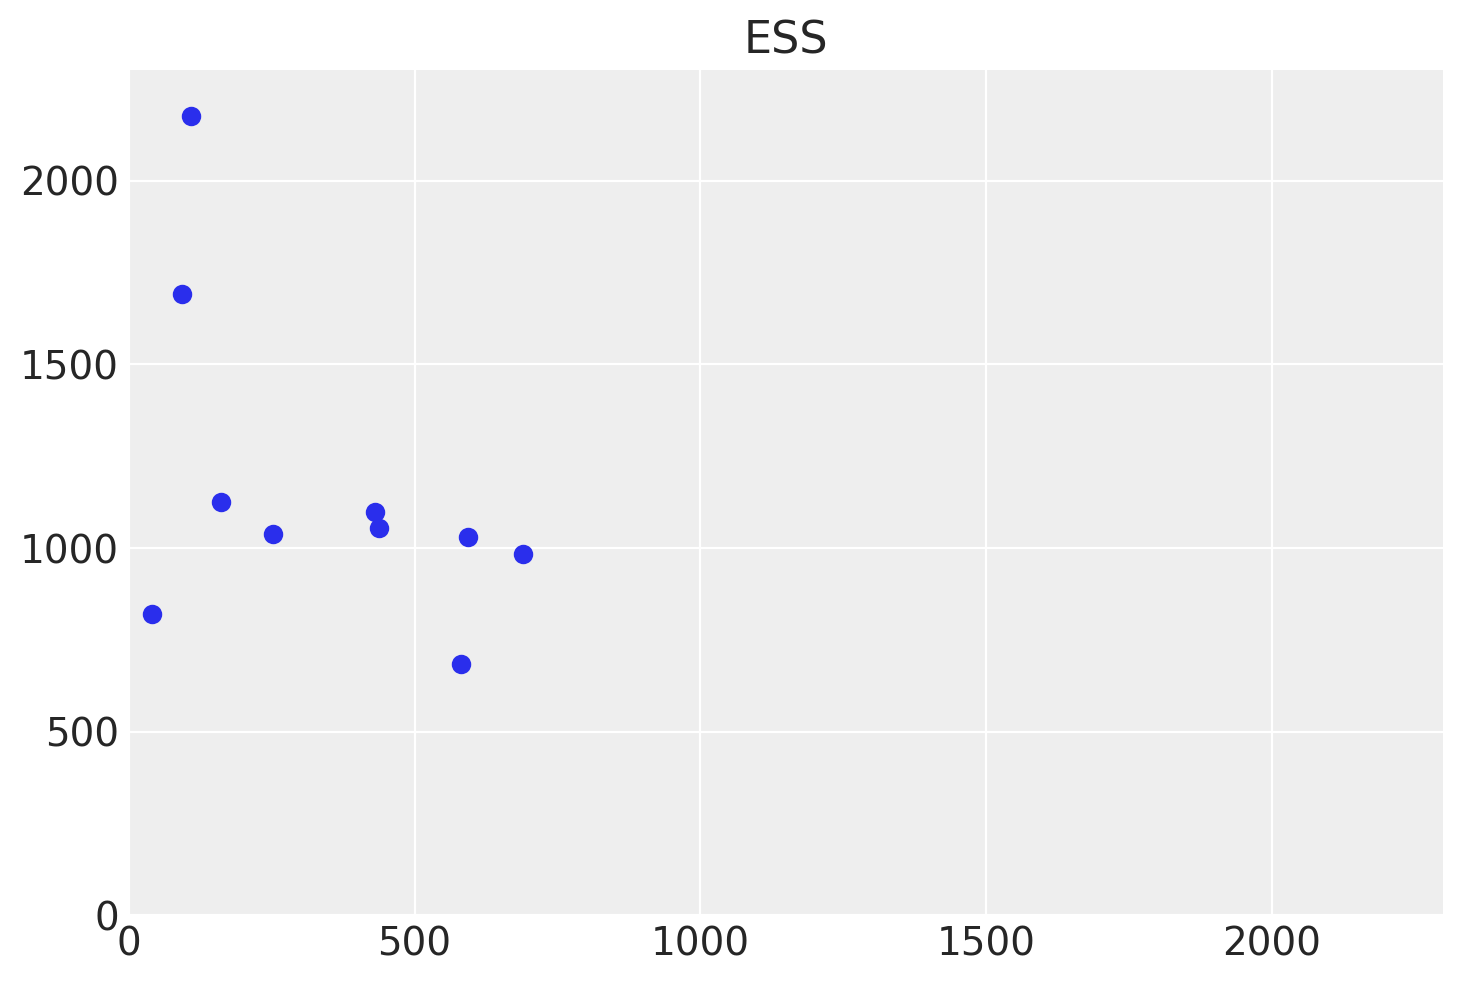

<IPython.core.display.Javascript object>

In [105]:
f, ax0 = plt.subplots()
ax0.scatter(
    az.summary(trace_mMVNc, var_names="lam")['ess_mean'],
    az.summary(trace_mMVNnc, var_names="lam")['ess_mean']
    )
ax0.set(xlim=[0, 2300], ylim=[0, 2300], title='ESS')

In [117]:
az.summary(trace_mMVNnc, var_names="chol")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
chol[0],1.248,0.761,0.253,2.192,0.022,0.016,1183.0,1183.0,862.0,882.0,1.00
chol[1],-0.005,0.279,-0.341,0.387,0.011,0.009,627.0,451.0,956.0,695.0,1.00
chol[2],0.819,0.729,0.019,1.662,0.032,0.022,534.0,534.0,513.0,366.0,1.01
chol[3],0.024,0.221,-0.307,0.305,0.006,0.005,1457.0,925.0,1599.0,1123.0,1.01
chol[4],-0.002,0.255,-0.310,0.362,0.009,0.007,879.0,610.0,1349.0,757.0,1.00
chol[5],0.686,0.652,0.026,1.441,0.025,0.018,655.0,655.0,545.0,716.0,1.00
chol[6],-0.003,0.162,-0.239,0.200,0.008,0.006,424.0,424.0,631.0,416.0,1.01
chol[7],0.001,0.174,-0.236,0.227,0.005,0.005,1298.0,634.0,1332.0,838.0,1.01
chol[8],0.015,0.222,-0.260,0.232,0.017,0.015,176.0,105.0,577.0,276.0,1.00
chol[9],0.476,0.520,0.011,1.054,0.030,0.022,304.0,269.0,327.0,334.0,1.00


<IPython.core.display.Javascript object>

In [118]:
az.summary(trace_mMVNnc, var_names="chol_corr")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_corr[0,1]",0.023,0.238,-0.347,0.417,0.006,0.005,1583.0,1177.0,1602.0,1307.0,1.00
"chol_corr[0,2]",0.041,0.239,-0.326,0.431,0.005,0.004,2250.0,1611.0,2278.0,2335.0,1.00
"chol_corr[0,3]",-0.024,0.228,-0.397,0.324,0.006,0.004,1595.0,1595.0,1636.0,2360.0,1.00
"chol_corr[0,4]",0.009,0.245,-0.343,0.438,0.006,0.004,1970.0,1540.0,2007.0,1085.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
"chol_corr[9,5]",-0.055,0.243,-0.472,0.307,0.008,0.006,997.0,867.0,997.0,1104.0,1.01
"chol_corr[9,6]",0.023,0.247,-0.385,0.399,0.007,0.007,1111.0,598.0,1171.0,492.0,1.01
"chol_corr[9,7]",-0.022,0.246,-0.408,0.387,0.007,0.005,1410.0,1410.0,1466.0,1715.0,1.00
"chol_corr[9,8]",0.042,0.236,-0.335,0.411,0.007,0.005,1296.0,1296.0,1315.0,1917.0,1.00


<IPython.core.display.Javascript object>

In [120]:
az.summary(trace_mMVNnc, var_names="chol_stds")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
chol_stds[0],1.248,0.761,0.253,2.192,0.022,0.016,1183.0,1183.0,862.0,882.0,1.00
chol_stds[1],0.845,0.753,0.019,1.710,0.033,0.023,517.0,517.0,502.0,376.0,1.01
chol_stds[2],0.731,0.690,0.027,1.512,0.028,0.020,602.0,602.0,519.0,717.0,1.00
chol_stds[3],0.525,0.572,0.011,1.158,0.035,0.028,264.0,212.0,308.0,277.0,1.00
chol_stds[4],0.435,0.515,0.017,0.987,0.035,0.025,216.0,216.0,175.0,463.0,1.02
chol_stds[5],0.944,0.713,0.083,1.755,0.047,0.033,235.0,235.0,253.0,360.0,1.02
chol_stds[6],0.472,0.552,0.019,1.083,0.057,0.041,92.0,92.0,101.0,207.0,1.04
chol_stds[7],0.564,0.571,0.019,1.247,0.047,0.033,147.0,147.0,75.0,139.0,1.05
chol_stds[8],0.901,0.701,0.037,1.771,0.055,0.039,163.0,159.0,194.0,217.0,1.02
chol_stds[9],1.064,0.631,0.252,1.958,0.041,0.029,234.0,234.0,252.0,393.0,1.01


<IPython.core.display.Javascript object>

Above gives the right dimensions.

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Ma

[(0.0, 100.0),
 (0.0, 100.0),
 Text(0.5, 0, 'centered'),
 Text(0, 0.5, 'non-centered'),
 Text(0.5, 1.0, 'Actual vs. model total tools (nc)')]

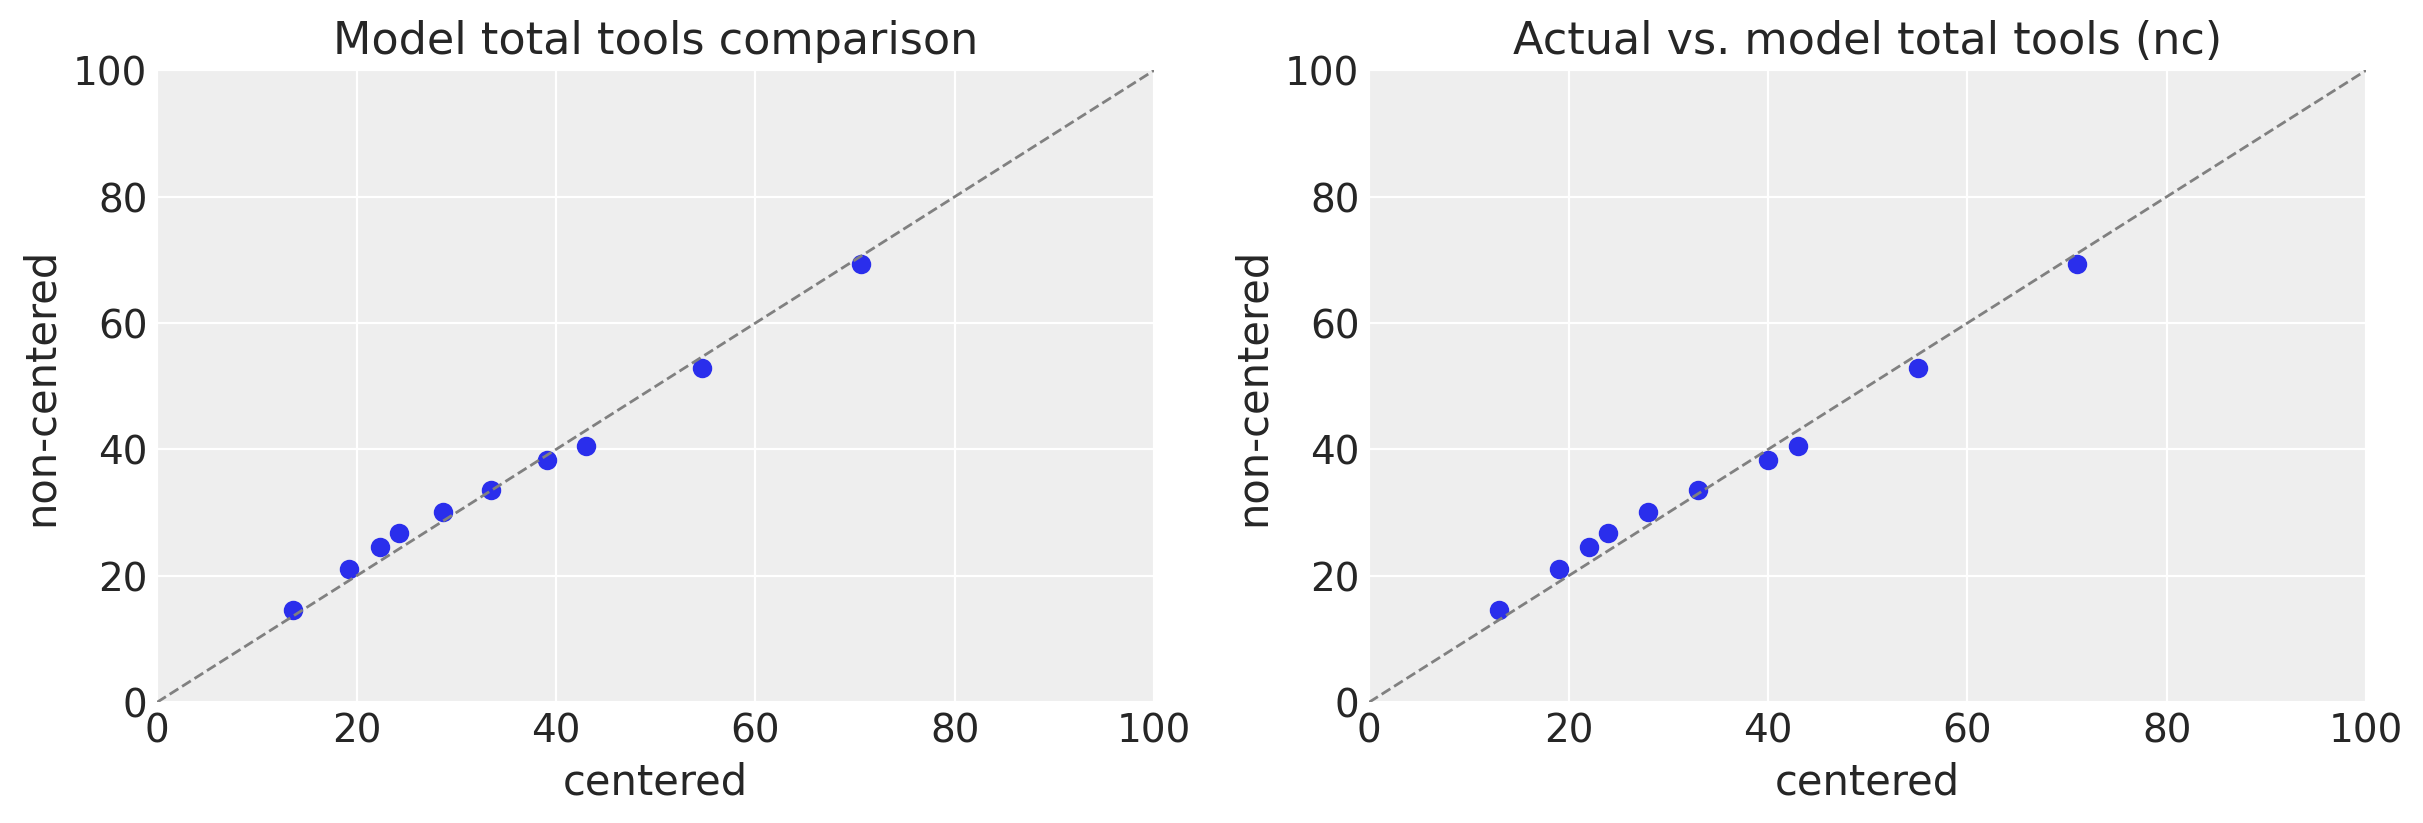

<IPython.core.display.Javascript object>

In [114]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax0.scatter(
    az.summary(trace_mMVNc, var_names="lam")['mean'],
    az.summary(trace_mMVNnc, var_names="lam")['mean']
    )
ax0.plot([0, 100], [0, 100], color="gray", lw=1, linestyle="--")
ax0.set(xlim=[0, 100], ylim=[0, 100], xlabel='centered', ylabel='non-centered', title='Model total tools comparison')


ax1.scatter(
    df_islands['total_tools'],
    az.summary(trace_mMVNnc, var_names="lam")['mean']
    )
ax1.plot([0, 100], [0, 100], color="gray", lw=1, linestyle="--")
ax1.set(xlim=[0, 100], ylim=[0, 100], xlabel='centered', ylabel='non-centered', title='Actual vs. model total tools (nc)')

## MVN with covariance matrix from GPR


We're modeling the underlying *function* and not the covariance parameters directly. The function has parameters and we will model that.

$$ f \sim GP(m(x), k(x, x')) $$

The *realization* of a covariance function is a covariance matrix.

$$ \Sigma \sim k(x, x' | \phi) $$

Here is one common covariance function, the exponential quadratic function:

$$ k(x,x') = \exp \left [ - \frac{(x-x')^2}{2l^2} \right] $$

We can write a function in code for this.

### Custom function

In [160]:
def exp_quad(dist, l):
    # dist will be x-x'
    return np.exp(-(dist)**2 / (2 * l**2))

<IPython.core.display.Javascript object>

Let's plot this function.

[Text(0.5, 0, 'distance'),
 Text(0, 0.5, 'k'),
 Text(0.5, 1.0, 'Exponential quadratic kernel function')]

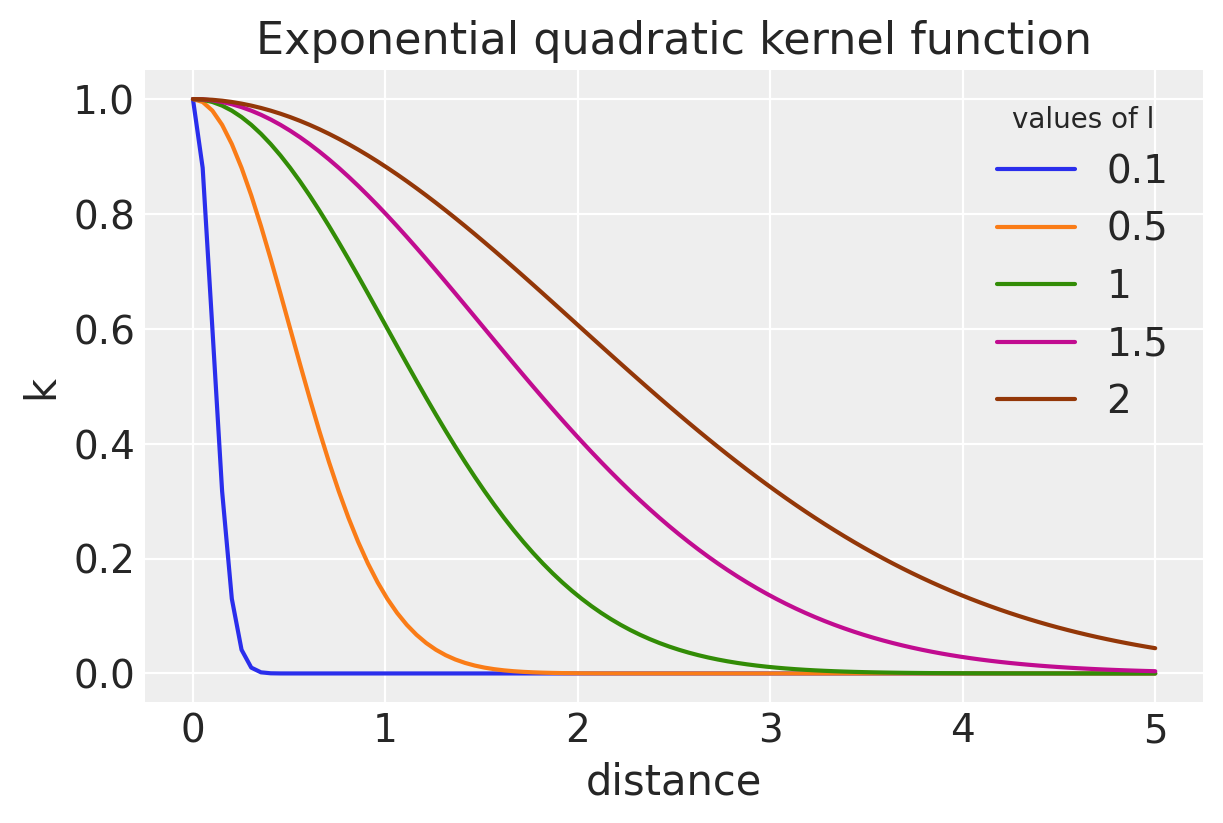

<IPython.core.display.Javascript object>

In [226]:
# sample from values of x and x_prime
dist = np.linspace(0, 5, 100)

l_vals = [0.1, 0.5, 1, 1.5, 2]

f, ax0 = plt.subplots(figsize=(6,4))
for l in l_vals:
    ax0.plot(dist, exp_quad(dist=dist, l=l), label=l)
ax0.legend(title='values of l')
ax0.set(xlabel='distance', ylabel='k', title='Exponential quadratic kernel function')

What does this imply in terms of what it means for our covariance matrix. Let's just take the green curve and limit ourselves to a few distances.

In [179]:
pd.DataFrame(
    {"dist":np.linspace(0, 6, 5),
    "k":exp_quad(dist=np.linspace(0, 6, 5), l=1)
    }
)

,dist,k
0,0.0,1.000000e+00
1,1.5,3.246525e-01
2,3.0,1.110900e-02
3,4.5,4.006530e-05
4,6.0,1.522998e-08


<IPython.core.display.Javascript object>

In [223]:
cov_d3 = exp_quad(dist=3, l=1)
cov_d3

0.011108996538242306

<IPython.core.display.Javascript object>

Remember that k is still a function.

In [224]:
k_cov = np.array([[1, cov_d3], [cov_d3, 1]])

<IPython.core.display.Javascript object>

In [225]:
stats.multivariate_normal.rvs(mean=[0,0], cov=k_cov, size=5)

array([[ 0.68566231, -1.3173124 ],
       [ 1.11512214,  0.11919482],
       [ 2.05534959, -2.45536881],
       [-1.18391534, -0.4785056 ],
       [-0.73384032,  1.21019446]])

<IPython.core.display.Javascript object>

### Using pymc functions

In [ ]:
ls = 1

# specify covariate function
cov_func_pm = pm.gp.cov.ExpQuad(ls=ls, input_dim=1)

# specify the GP, default mean vector is zero
gp = pm.gp.Latent(cov_func_pm)

<IPython.core.display.Javascript object>

In [ ]:
X = np.linspace(0, 1, 10)[:,None]
X

array([[0.        ],
       [0.11111111],
       [0.22222222],
       [0.33333333],
       [0.44444444],
       [0.55555556],
       [0.66666667],
       [0.77777778],
       [0.88888889],
       [1.        ]])

<IPython.core.display.Javascript object>

In [ ]:
# won't run outside a model context
# f = gp.prior("f", X=X)

<IPython.core.display.Javascript object>

We need to use a model context.

In [240]:
# A one dimensional column vector of inputs.
X = np.linspace(0, 5, 10)[:,None]

with pm.Model() as latent_gp_model:
    
    # Specify the covariance function
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=1)

    # Specify the Gaussian process.  The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov_func)

    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)    # X is where our distances are actually inputted

    trace_lgm = pm.sample(1000, chains=2, cores=1, return_inferencedata=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [f_rotated_]
INFO:pymc3:NUTS: [f_rotated_]


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


<IPython.core.display.Javascript object>

I want to check the values of the gaussian process function, but it's not available to retrieve.

In [241]:
trace_lgm.varnames

['f_rotated_', 'f']

<IPython.core.display.Javascript object>

In [242]:
(trace_lgm.get_values('f')).shape

(2000, 10)

<IPython.core.display.Javascript object>

In [245]:
X

array([[0.        ],
       [0.55555556],
       [1.11111111],
       [1.66666667],
       [2.22222222],
       [2.77777778],
       [3.33333333],
       [3.88888889],
       [4.44444444],
       [5.        ]])

<IPython.core.display.Javascript object>

In [232]:
X[0][0]

0.0

<IPython.core.display.Javascript object>

In [248]:
X[i][0]

0.0

<IPython.core.display.Javascript object>

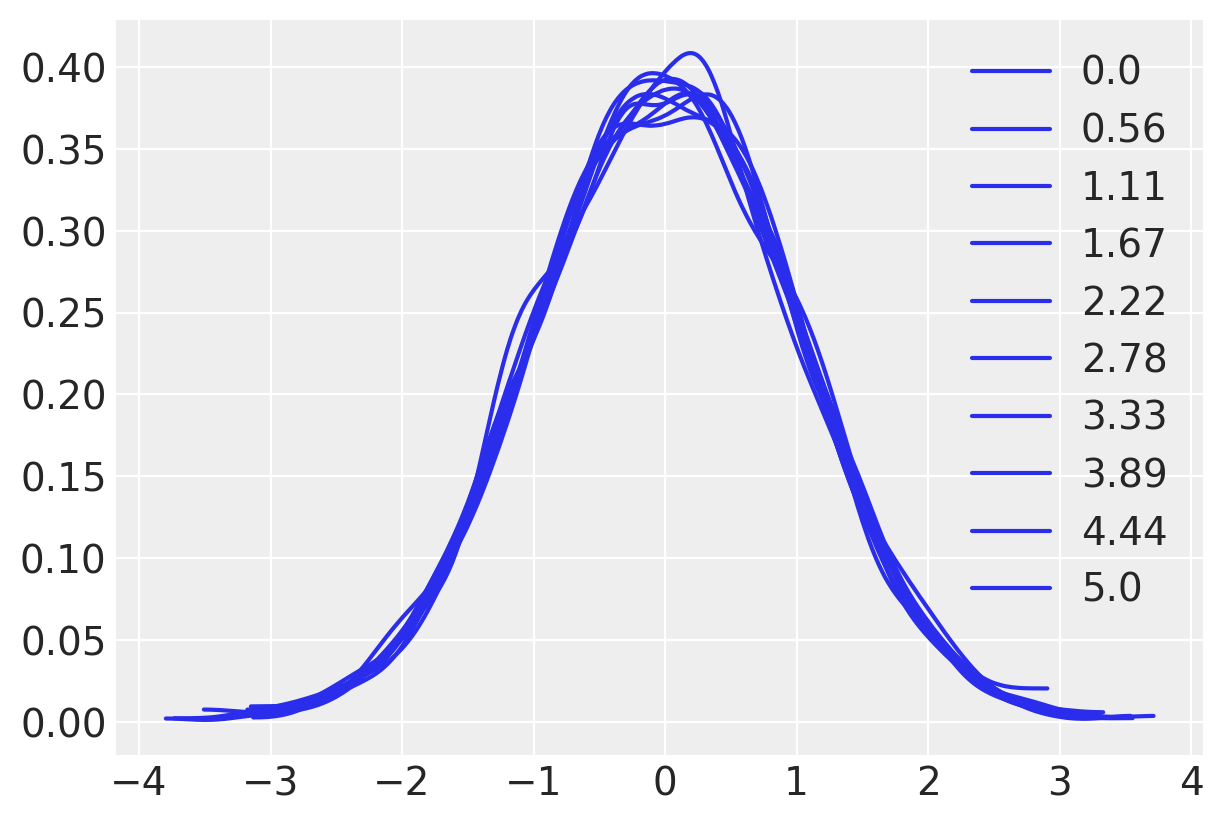

<IPython.core.display.Javascript object>

In [249]:
f, ax0 = plt.subplots(figsize=(6,4))
for i in range(len(X)):
    # print(trace_lgm.get_values('f')[0:5, i])
    az.plot_kde(trace_lgm.get_values('f')[:, i], label=f"{round(X[i][0],2)}", ax=ax0)
    # az.plot_density(trace_lgm.get_values('f')[:, i], ax=ax0)
ax0.legend()

In [171]:
np.linspace(0, 5, 5)

array([0.  , 1.25, 2.5 , 3.75, 5.  ])

<IPython.core.display.Javascript object>

In [ ]:
with pm.Model() as m14_8:
    a = pm.Exponential("a", 1.0)
    b = pm.Exponential("b", 1.0)
    g = pm.Exponential("g", 1.0)

    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv ** 2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    lam = (a * P ** b / g) * tt.exp(k[society])

    T = pm.Poisson("total_tools", lam, observed=total_tools)

    trace_14_8 = pm.sample(4000, tune=2000, target_accept=0.99, random_seed=RANDOM_SEED)
    idata_14_8 = az.from_pymc3(trace_14_8, dims={"k": ["society"]})

In [135]:
etasq = pm.Exponential.dist(2.0).random(size=1)
etasq

array([0.03313453])

<IPython.core.display.Javascript object>

In [136]:
ls_inv = pm.HalfNormal.dist(2.0).random(size=1)
ls_inv

array([0.15881979])

<IPython.core.display.Javascript object>

In [137]:
rhosq = 0.5 * ls_inv ** 2
rhosq

array([0.01261186])

<IPython.core.display.Javascript object>

In [262]:
cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)   # This is the kernel
cov

<IPython.core.display.Javascript object>

In [267]:
list(filter(lambda x: "__" not in x, dir(cov)))

['_slice',
 'active_dims',
 'diag',
 'factor_list',
 'full',
 'input_dim',
 'merge_factors']

<IPython.core.display.Javascript object>

In [270]:
cov.input_dim

1

<IPython.core.display.Javascript object>

In [261]:
pm.gp.cov.ExpQuad.dist(input_dim=1, ls_inv=ls_inv).random(size=1)

AttributeError: type object 'ExpQuad' has no attribute 'dist'

<IPython.core.display.Javascript object>

In [140]:
gp = pm.gp.Latent(cov_func=cov)
gp

<IPython.core.display.Javascript object>

In [143]:
# gp.prior("k", X=Dmat)

<IPython.core.display.Javascript object>

In [ ]:
with pm.Model() as m14_8:
    a = pm.Exponential("a", 1.0)
    b = pm.Exponential("b", 1.0)
    g = pm.Exponential("g", 1.0)

    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv ** 2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    lam = (a * P ** b / g) * tt.exp(k[society])

    T = pm.Poisson("total_tools", lam, observed=total_tools)

    trace_14_8 = pm.sample(4000, tune=2000, target_accept=0.99, random_seed=RANDOM_SEED)
    idata_14_8 = az.from_pymc3(trace_14_8, dims={"k": ["society"]})

In [154]:
Dmat

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884
Trobriand,2.036,2.007,1.708,2.462,3.219,0.000,1.801,0.850,3.893,6.653
Chuuk,3.178,2.877,2.588,1.555,4.027,1.801,0.000,1.213,4.789,5.787
Manus,2.794,2.670,2.356,1.616,3.906,0.850,1.213,0.000,4.622,6.722
Tonga,1.860,1.965,2.279,6.136,0.763,3.893,4.789,4.622,0.000,5.037
Hawaii,5.678,5.283,5.401,7.178,4.884,6.653,5.787,6.722,5.037,0.000


<IPython.core.display.Javascript object>

In [155]:
with pm.Model() as mMVNgpr:
    """
    GPR model
    """

    # vector of means for MVNormal
    mus = pm.Normal("mus", mu=0, sd=1, shape=n_islands)

    # priors for for covariance kernel function
    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)

    a = pm.MvNormal(
        "a", mu=mus, chol=k[id_isle], shape=n_islands
    )  # population of varying effects
    # shape needs to be ... 

    # linear models
    lam = pm.Deterministic("lam", pm.math.exp(a_bar + a[id_isle]))

    # likelihood
    t = pm.Poisson("t", lam, observed=df_islands['total_tools'])

    trace_mMVNgpr = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


TypeError: '(slice(None, None, None), array([0]))' is an invalid key

<IPython.core.display.Javascript object>

In [147]:
with pm.Model() as mMVNgpr:
    """
    GPR model
    """

    # vector of means for MVNormal
    mus = pm.Normal("mus", mu=0, sd=1, shape=n_islands)
    K = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)

    a = pm.MvNormal(
        "a", mu=mus, cov=K
    )  # population of varying effects
    # shape needs to be ... 

    # linear models
    lam = pm.Deterministic("lam", pm.math.exp(a_bar + a[id_isle]))

    # likelihood
    t = pm.Poisson("t", lam, observed=df_islands['total_tools'])

    trace_mMVNgpr = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

AttributeError: 'Prod' object has no attribute 'shape'

<IPython.core.display.Javascript object>

## Back to Islands problem with pymc functions

In [256]:
Dmat.values

array([[0.   , 0.475, 0.631, 4.363, 1.234, 2.036, 3.178, 2.794, 1.86 ,
        5.678],
       [0.475, 0.   , 0.315, 4.173, 1.236, 2.007, 2.877, 2.67 , 1.965,
        5.283],
       [0.631, 0.315, 0.   , 3.859, 1.55 , 1.708, 2.588, 2.356, 2.279,
        5.401],
       [4.363, 4.173, 3.859, 0.   , 5.391, 2.462, 1.555, 1.616, 6.136,
        7.178],
       [1.234, 1.236, 1.55 , 5.391, 0.   , 3.219, 4.027, 3.906, 0.763,
        4.884],
       [2.036, 2.007, 1.708, 2.462, 3.219, 0.   , 1.801, 0.85 , 3.893,
        6.653],
       [3.178, 2.877, 2.588, 1.555, 4.027, 1.801, 0.   , 1.213, 4.789,
        5.787],
       [2.794, 2.67 , 2.356, 1.616, 3.906, 0.85 , 1.213, 0.   , 4.622,
        6.722],
       [1.86 , 1.965, 2.279, 6.136, 0.763, 3.893, 4.789, 4.622, 0.   ,
        5.037],
       [5.678, 5.283, 5.401, 7.178, 4.884, 6.653, 5.787, 6.722, 5.037,
        0.   ]])

<IPython.core.display.Javascript object>

In [257]:
with pm.Model() as mGPR0:
    
    # GP hyperpriors
    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    a = gp.prior("a", X=Dmat.values)

    # linear models
    lam = pm.Deterministic("lam", pm.math.exp(a_bar + a[id_isle]))

    # likelihood
    t = pm.Poisson("t", lam, observed=df_islands['total_tools'])

    trace_mGPR0 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_rotated_, ls_inv, etasq]
INFO:pymc3:NUTS: [a_rotated

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters

<IPython.core.display.Javascript object>

In [258]:
az.summary(trace_mGPR0)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_rotated_[0],-1.409,0.480,-2.109,-0.649,0.011,0.008,1811.0,1811.0,1816.0,2495.0,1.00
a_rotated_[1],-0.289,0.578,-1.248,0.455,0.034,0.024,285.0,285.0,415.0,211.0,1.01
a_rotated_[2],-0.244,0.690,-1.299,0.877,0.015,0.011,2028.0,1809.0,2038.0,2297.0,1.00
a_rotated_[3],0.342,0.304,-0.110,0.823,0.007,0.007,1776.0,1050.0,2015.0,1349.0,1.00
a_rotated_[4],0.057,0.497,-0.660,0.841,0.016,0.013,962.0,687.0,1124.0,649.0,1.00
a_rotated_[5],-0.586,0.398,-1.221,-0.031,0.012,0.011,1071.0,635.0,1350.0,1064.0,1.00
a_rotated_[6],0.188,0.341,-0.301,0.685,0.012,0.010,782.0,609.0,1152.0,639.0,1.00
a_rotated_[7],-0.453,0.507,-1.226,0.258,0.018,0.013,774.0,774.0,1069.0,425.0,1.00
a_rotated_[8],1.597,0.860,0.322,2.939,0.047,0.033,342.0,342.0,465.0,330.0,1.01
a_rotated_[9],1.163,0.423,0.590,1.798,0.015,0.010,824.0,824.0,1035.0,655.0,1.01


<IPython.core.display.Javascript object>

In [272]:
Dmat.values

array([[0.   , 0.475, 0.631, 4.363, 1.234, 2.036, 3.178, 2.794, 1.86 ,
        5.678],
       [0.475, 0.   , 0.315, 4.173, 1.236, 2.007, 2.877, 2.67 , 1.965,
        5.283],
       [0.631, 0.315, 0.   , 3.859, 1.55 , 1.708, 2.588, 2.356, 2.279,
        5.401],
       [4.363, 4.173, 3.859, 0.   , 5.391, 2.462, 1.555, 1.616, 6.136,
        7.178],
       [1.234, 1.236, 1.55 , 5.391, 0.   , 3.219, 4.027, 3.906, 0.763,
        4.884],
       [2.036, 2.007, 1.708, 2.462, 3.219, 0.   , 1.801, 0.85 , 3.893,
        6.653],
       [3.178, 2.877, 2.588, 1.555, 4.027, 1.801, 0.   , 1.213, 4.789,
        5.787],
       [2.794, 2.67 , 2.356, 1.616, 3.906, 0.85 , 1.213, 0.   , 4.622,
        6.722],
       [1.86 , 1.965, 2.279, 6.136, 0.763, 3.893, 4.789, 4.622, 0.   ,
        5.037],
       [5.678, 5.283, 5.401, 7.178, 4.884, 6.653, 5.787, 6.722, 5.037,
        0.   ]])

<IPython.core.display.Javascript object>

In [271]:
exp_quad(dist=2, l=2)

0.6065306597126334

<IPython.core.display.Javascript object>

In [276]:
etasq_mean = az.summary(trace_mGPR0).loc['etasq', 'mean']
l_mean = 1/az.summary(trace_mGPR0).loc['ls_inv', 'mean']

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<IPython.core.display.Javascript object>

In [281]:
K_post = np.zeros((n_islands, n_islands))
for i in range(10):
    for j in range(10):
        dist = Dmat.values[i, j]
        kij = etasq_mean * exp_quad(dist=dist, l=l_mean)
        #print(i,j, kij)
        K_post[i, j] = kij


<IPython.core.display.Javascript object>

In [282]:
pd.DataFrame(K_post)

,0,1,2,3,4,5,6,7,8,9
0,4.050000e-01,1.239188e-01,5.009993e-02,1.640386e-44,1.368658e-04,1.439295e-10,3.845688e-24,6.493666e-19,5.262726e-09,1.307053e-74
1,1.239188e-01,4.050000e-01,2.405853e-01,8.165272e-41,1.333626e-04,2.663282e-10,5.489510e-20,2.274836e-17,6.392880e-10,9.676378e-65
2,5.009993e-02,2.405853e-01,4.050000e-01,4.581860e-35,1.351750e-06,9.067325e-08,2.186658e-16,9.003559e-14,5.860913e-13,1.293864e-67
3,1.640386e-44,8.165272e-41,4.581860e-35,4.050000e-01,2.279790e-67,6.169396e-15,1.245968e-06,4.514151e-07,6.056375e-87,1.438585e-118
4,1.368658e-04,1.333626e-04,1.351750e-06,2.279790e-67,4.050000e-01,9.707495e-25,4.375401e-38,6.747110e-36,1.907156e-02,1.709656e-55
5,1.439295e-10,2.663282e-10,9.067325e-08,6.169396e-15,9.707495e-25,4.050000e-01,1.635256e-08,9.130579e-03,1.148767e-35,5.130889e-102
6,3.845688e-24,5.489510e-20,2.186658e-16,1.245968e-06,4.375401e-38,1.635256e-08,4.050000e-01,1.792391e-04,2.126395e-53,1.851848e-77
7,6.493666e-19,2.274836e-17,9.003559e-14,4.514151e-07,6.747110e-36,9.130579e-03,1.792391e-04,4.050000e-01,8.132602e-50,4.040881e-104
8,5.262726e-09,6.392880e-10,5.860913e-13,6.056375e-87,1.907156e-02,1.148767e-35,2.126395e-53,8.132602e-50,4.050000e-01,5.926363e-59
9,1.307053e-74,9.676378e-65,1.293864e-67,1.438585e-118,1.709656e-55,5.130889e-102,1.851848e-77,4.040881e-104,5.926363e-59,4.050000e-01


<IPython.core.display.Javascript object>

In [252]:
Dmat

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884
Trobriand,2.036,2.007,1.708,2.462,3.219,0.000,1.801,0.850,3.893,6.653
Chuuk,3.178,2.877,2.588,1.555,4.027,1.801,0.000,1.213,4.789,5.787
Manus,2.794,2.670,2.356,1.616,3.906,0.850,1.213,0.000,4.622,6.722
Tonga,1.860,1.965,2.279,6.136,0.763,3.893,4.789,4.622,0.000,5.037
Hawaii,5.678,5.283,5.401,7.178,4.884,6.653,5.787,6.722,5.037,0.000


<IPython.core.display.Javascript object>

Text(0, 0.5, 'covariance')

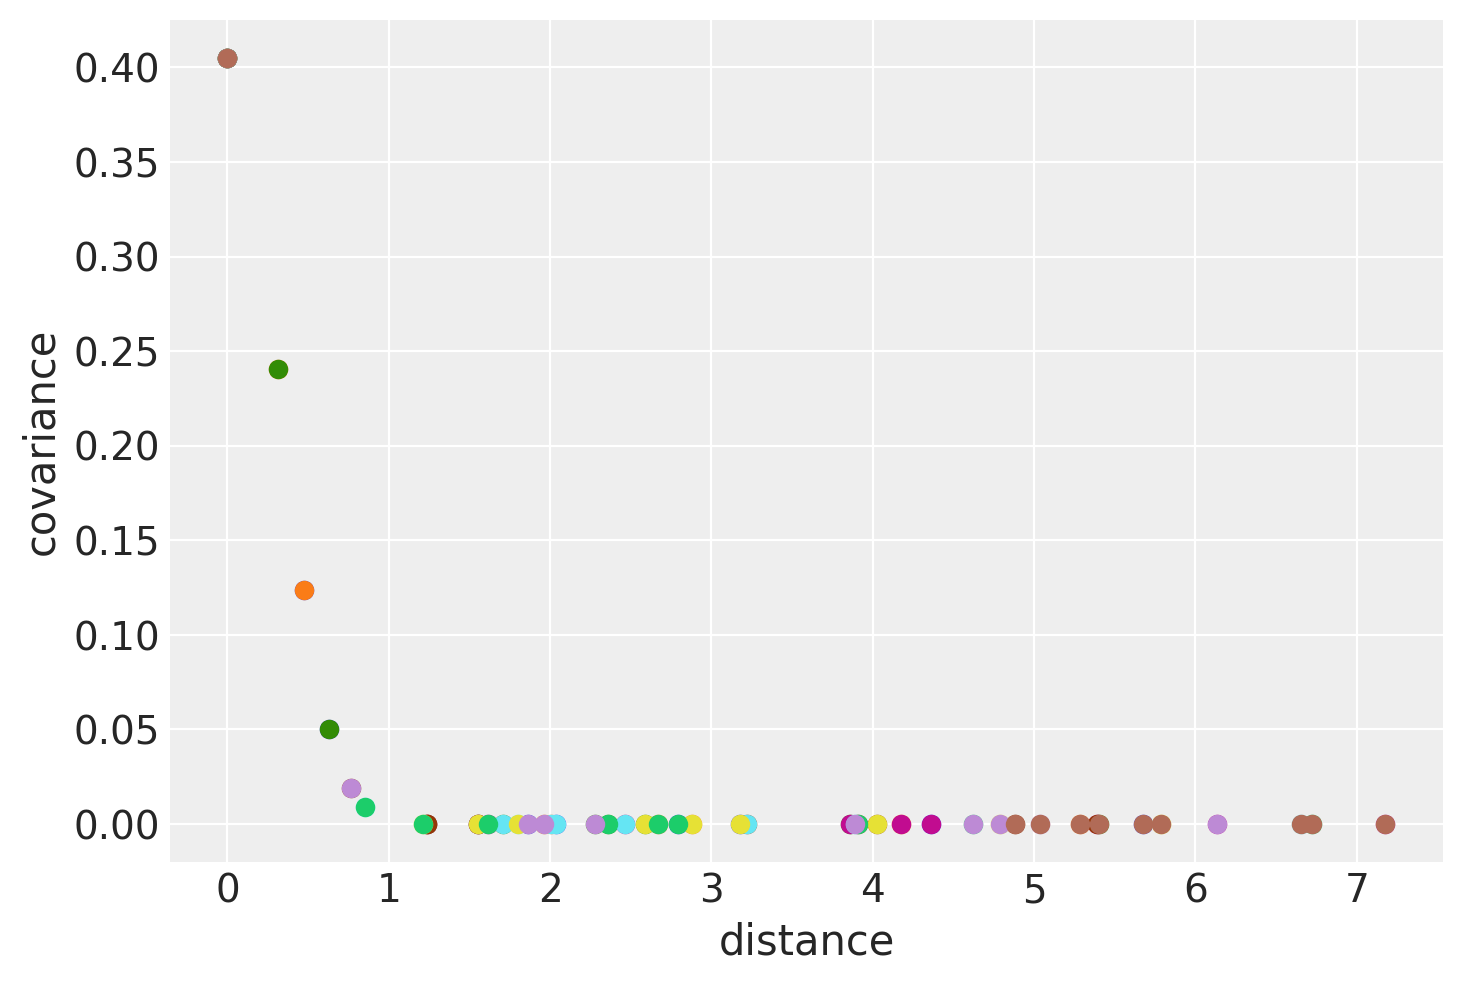

<IPython.core.display.Javascript object>

In [285]:
for i in range(10):
    plt.scatter(Dmat.values[:, i], K_post[:, i])

plt.xlabel('distance')
plt.ylabel('covariance')

In [ ]:
with pm.Model() as mMVNc:
    """
    Centered model
    """

    # vector of means for MVNormal
    mus = pm.Normal("mus", mu=0, sd=1, shape=n_islands)

    # variances for covariance matrix
    sd_dist = pm.Exponential.dist(1.0)
    chol, corr, sigmas = pm.LKJCholeskyCov("chol", n=n_islands, eta=4, sd_dist=sd_dist, compute_corr=True)
    # n=2 for each pair of islands

    a = pm.MvNormal(
        "a", mu=mus, chol=chol, shape=n_islands
    )  # population of varying effects
    # shape needs to be ... 

    # linear models
    lam = pm.Deterministic("lam", pm.math.exp(a_bar + a[id_isle]))

    # likelihood
    t = pm.Poisson("t", lam, observed=df_islands['total_tools'])

    trace_mMVNc = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

# Summary

In [70]:
%watermark -n -u -v -iv -w

Last updated: Tue Mar 15 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pymc3     : 3.11.0
pandas    : 1.2.1
sys       : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
theano    : 1.1.0
matplotlib: 3.3.4
arviz     : 0.11.1
scipy     : 1.6.0
numpy     : 1.20.1
seaborn   : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>